# Prepare raw data for curvecurator

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pubchempy as pcp
from Bio.ExPASy import cellosaurus
import toml
from drevalpy.datasets.curvecurator import preprocess, _exec_curvecurator, postprocess

## Load Data

In [2]:
RAW_FILE_PATH = Path("raw/v10.D2.avg_pct_viability_data.txt")

In [3]:
raw_df = pd.read_csv(RAW_FILE_PATH, sep='\t')
raw_df = raw_df.sort_values(["ccl_name", "cpd_name", "cpd_conc_umol"])
raw_df

,ccl_name,cpd_name,well_role,cpd_conc_umol,cpd_avg_pv
195409,5637,(-)-gallocatechin-3-monogallate,Cpd,0.2890,0.907442
195410,5637,(-)-gallocatechin-3-monogallate,Cpd,0.5780,0.903863
195411,5637,(-)-gallocatechin-3-monogallate,Cpd,1.1563,0.942774
195412,5637,(-)-gallocatechin-3-monogallate,Cpd,2.3123,0.899073
195413,5637,(-)-gallocatechin-3-monogallate,Cpd,4.6250,0.933793
...,...,...,...,...,...
46034,WSUDLCL2,zileuton,Cpd,33.3330,0.933906
46035,WSUDLCL2,zileuton,Cpd,66.6670,1.032896
46036,WSUDLCL2,zileuton,Cpd,133.3300,0.934276
46037,WSUDLCL2,zileuton,Cpd,266.6700,0.869657


## Prepare data

In [4]:
## fix low doses that are similar to the 6th digit
raw_df.loc[raw_df.cpd_conc_umol == 0.0040623, 'cpd_conc_umol'] = 0.0040625
raw_df.loc[raw_df.cpd_conc_umol == 0.0040627, 'cpd_conc_umol'] = 0.0040625

raw_df.loc[raw_df.cpd_conc_umol == 0.0020312, 'cpd_conc_umol'] = 0.00203125
raw_df.loc[raw_df.cpd_conc_umol == 0.0020313, 'cpd_conc_umol'] = 0.00203125

In [5]:
# make pubchem_cids to ints
drug_df = pd.read_csv("meta/v10.M1.informer_set.txt", sep="\t")
drug_df["pubchem_cid"] = drug_df.pubchem_cid.fillna(-1).astype(int)

In [6]:
full_df = raw_df.merge(drug_df, on="cpd_name")

## Creating replicate information

In [7]:
full_df["maxdose"] = full_df.groupby(["ccl_name", "cpd_name"])["cpd_conc_umol"].transform("max")
full_df["mindose"] = full_df.groupby(["ccl_name", "cpd_name"])["cpd_conc_umol"].transform("min")
full_df["replicate"] = full_df.groupby(["cpd_conc_umol", "ccl_name", "cpd_name"]).cumcount() + 1
full_df["nreplicates"] = full_df.groupby(["ccl_name", "cpd_name"])["replicate"].transform("max")
full_df

,ccl_name,cpd_name,well_role,cpd_conc_umol,cpd_avg_pv,cpd_synonym,cpd_status,target_or_activity_of_compound,gene_symbol_of_protein_target,top_test_conc_umol,percent_cpd_purity,cpd_smiles,pubchem_cid,broad_cpd_id,master_cpd_id,maxdose,mindose,replicate,nreplicates
0,5637,(-)-gallocatechin-3-monogallate,Cpd,0.2890,0.907442,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,NaN,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@@...,199472,BRD-K19216856,411730,37.000,0.28900,1,1
1,5637,(-)-gallocatechin-3-monogallate,Cpd,0.5780,0.903863,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,NaN,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@@...,199472,BRD-K19216856,411730,37.000,0.28900,1,1
2,5637,(-)-gallocatechin-3-monogallate,Cpd,1.1563,0.942774,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,NaN,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@@...,199472,BRD-K19216856,411730,37.000,0.28900,1,1
3,5637,(-)-gallocatechin-3-monogallate,Cpd,2.3123,0.899073,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,NaN,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@@...,199472,BRD-K19216856,411730,37.000,0.28900,1,1
4,5637,(-)-gallocatechin-3-monogallate,Cpd,4.6250,0.933793,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,NaN,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@@...,199472,BRD-K19216856,411730,37.000,0.28900,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523804,SNU449,trans-C 75,Cpd,2.0833,1.110169,C-75,probe,inhibitor of fatty acid synthase,FASN,33.33,NaN,CCCCCCCC[C@@H]1OC(=O)C(=C)[C@H]1C(=O)O.CCCCCCC...,-1,BRD-A03397005,594662,33.333,0.26033,1,1
523805,SNU449,trans-C 75,Cpd,4.1667,1.035975,C-75,probe,inhibitor of fatty acid synthase,FASN,33.33,NaN,CCCCCCCC[C@@H]1OC(=O)C(=C)[C@H]1C(=O)O.CCCCCCC...,-1,BRD-A03397005,594662,33.333,0.26033,1,1
523806,SNU449,trans-C 75,Cpd,8.3333,1.047151,C-75,probe,inhibitor of fatty acid synthase,FASN,33.33,NaN,CCCCCCCC[C@@H]1OC(=O)C(=C)[C@H]1C(=O)O.CCCCCCC...,-1,BRD-A03397005,594662,33.333,0.26033,1,1
523807,SNU449,trans-C 75,Cpd,16.6670,1.109359,C-75,probe,inhibitor of fatty acid synthase,FASN,33.33,NaN,CCCCCCCC[C@@H]1OC(=O)C(=C)[C@H]1C(=O)O.CCCCCCC...,-1,BRD-A03397005,594662,33.333,0.26033,1,1


## Drugname to PubChem mapping

In [8]:
full_df.query("pubchem_cid == -1")[["cpd_name", "broad_cpd_id","cpd_synonym", "cpd_smiles", "pubchem_cid"]].drop_duplicates()

,cpd_name,broad_cpd_id,cpd_synonym,cpd_smiles,pubchem_cid
6195,"2,4-dideoxy-DC-45-A2",BRD-K41087962,NaN,COC(OC)[C@]12O[C@@H]3[C@H](O1)[C@@](O)(Oc4c3c(...,-1
22774,6-diazo-5-oxo-L-norleucine,BRD-K84924563,diazooxonorleucine;DON;L-DON,N[C@@H](CCC(=O)C[N+]#N)C(=O)O,-1
61553,BRD2649,BRD-K26312649,NaN,CNC[C@@H]1OCC=CC[C@@H](C)Oc2ccc(cc2C(=O)N(C[C@...,-1
72620,BRD9786,BRD-K94679786,NaN,CC(C)N1C[C@@H](C)[C@H](CN(C)Cc2ccc3OCOc3c2)OCC...,-1
89900,Compound 10b,BRD-K18190982,NaN,NC(=C)c1cc2c(cnc(N)c2s1)c3cccc(c3)c4ccccc4,-1
107492,DC-45-A2,BRD-K79983625,NaN,COC(OC)[C@]12O[C@@H]3[C@H](O1)[C@@](O)(Oc4c3c(...,-1
194011,PP-30,BRD-K30677119,NaN,CC(C)n1nc(c2cccc(c2)C(=O)NC3=NCCC3)c4c(N)ncnc14,-1
198155,PRL-3 Inhibitor I,BRD-K09907482,NaN,Brc1ccc(OCc2ccccc2Br)c(\C=C/3\SC(=S)NC3=O)c1,-1
234957,WT-161,BRD-K74761218,NaN,ONC(=O)CCCCCCC(=O)N\N=C\c1ccc(cc1)N(c2ccccc2)c...,-1
298083,iso-DC-45-A2,BRD-K51759822,NaN,COC(OC)[C@@]12O[C@H]3[C@H](O1)[C@](O)(Oc4c3c(C...,-1


In [9]:
for smile in full_df.query("pubchem_cid == -1")[["cpd_name", "cpd_synonym", "cpd_smiles", "pubchem_cid"]].drop_duplicates().cpd_smiles:
    print(smile)

COC(OC)[C@]12O[C@@H]3[C@H](O1)[C@@](O)(Oc4c3c(C)cc5c(OC)c6CCCC(=O)c6c(O)c45)[C@@]27CO7
N[C@@H](CCC(=O)C[N+]#N)C(=O)O
CNC[C@@H]1OCC=CC[C@@H](C)Oc2ccc(cc2C(=O)N(C[C@H]1C)[C@@H](C)CO)N(C)C
CC(C)N1C[C@@H](C)[C@H](CN(C)Cc2ccc3OCOc3c2)OCCCC[C@@H](C)Oc4ccc(cc4C1=O)N(C)C
NC(=C)c1cc2c(cnc(N)c2s1)c3cccc(c3)c4ccccc4
COC(OC)[C@]12O[C@@H]3[C@H](O1)[C@@](O)(Oc4c3c(C)cc5c(OC)c6[C@@H](O)C[C@H](O)C(=O)c6c(O)c45)[C@@]27CO7
CC(C)n1nc(c2cccc(c2)C(=O)NC3=NCCC3)c4c(N)ncnc14
Brc1ccc(OCc2ccccc2Br)c(\C=C/3\SC(=S)NC3=O)c1
ONC(=O)CCCCCCC(=O)N\N=C\c1ccc(cc1)N(c2ccccc2)c3ccccc3
COC(OC)[C@@]12O[C@H]3[C@H](O1)[C@](O)(Oc4c3c(C)cc5c(OC)c6[C@@H](O)C[C@H](O)C(=O)c6c(O)c45)[C@@]27CO7
COC(OC)C12OC3C(O1)C(O)(Oc4c3c(C)cc5c(OC)c6CCCC(=O)c6c(O)c45)C27CO7
CO[C@@H]1C[C@H](C[C@@H](C)[C@@H]2CC(=O)[C@H](C)\C=C(/C)\[C@@H](O)[C@@H](OC)C(=O)[C@H](C)C[C@H](C)\C=C\C=C\C=C(/C)\[C@H](CC3CC[C@@H](C)[C@@](O)(O3)C(=O)C(=O)N4CCCC[C@H]4C(=O)O2)OC)CCC1O
CO[C@@H]1CC(CC[C@H]1O)\C=C(/C)\[C@H]2OC(=O)[C@@H]3CCCCN3C(=O)C(=O)[C@]4(O)O[C@H]([C@H](CC(C

In [10]:
## via manual SMILES search in PubChem
results = {}
results['2,4-dideoxy-DC-45-A2'] = '73707381'
results['6-diazo-5-oxo-L-norleucine'] = '73707377'
results['BRD2649'] = 'BRD2649'                            # not found
results['BRD9786'] = 'BRD9786'                            # not found
results['Compound 10b'] = '73707373'
results['DC-45-A2'] = '73707376'
results['PP-30'] = '73707372'
results['PRL-3 Inhibitor I'] = '73707371'
results['WT-161'] = '121596287'
results['iso-DC-45-A2'] = 'iso-DC-45-A2'                  # not found
results['racemic-2,4-dideoxy-DC-45-A2'] = '126757334'
results['sirolimus'] = '5284616'                          # via name search, SMILES did not hit
results['tacrolimus'] = '445643'                          # via name search, SMILES did not hit
results['BRD2762'] = 'BRD2762'                            # not found
results['BRD5802'] = 'BRD5802'                            # not found
results['BRD6150'] = 'BRD6150'                            # not found
results['BRD9658'] = 'BRD9658'                            # not found

results['CIL55A'] = '168313047'
results['chaetocin'] = '137549100'
results['BRD2296'] = 'BRD2296'                            # not found
results['BRD9571'] = 'BRD9571'                            # not found
results['PL-DI'] = '73707398'
results['pandacostat'] = '136350280'
results['trans-C 75'] = '90488767'


## Cell line name to Cellosaurus Mapping

In [11]:
# Download Cellosaurus data in OBO format
url = "ftp://ftp.expasy.org/databases/cellosaurus/cellosaurus.txt"
filename = "../../CTRP/v2/cellosaurus.txt"
urllib.request.urlretrieve(url, filename)

In [12]:
cl_mappings = {}
btos = {}
with open(filename) as handle:
    records = cellosaurus.parse(handle)
    for record in records:
        if 'Homo sapiens' in record['OX'][0]:
            if record["ID"] not in cl_mappings:
                cl_mappings[record["ID"]] = []
            cl_mappings[record["ID"]].append(record["AC"])
            syns = record["SY"].split("; ")
            for syn in syns:
                if syn == '':
                    continue
                if syn not in cl_mappings:
                    cl_mappings[syn] = []
                cl_mappings[syn].append(record["AC"])
            for a, b in record["DR"]:
                if a == 'BTO':
                    if record["AC"] not in btos:
                        btos[record["AC"]] = []
                    btos[record["AC"]].append(b)

In [13]:
ccls = full_df["ccl_name"].unique()
mappings = {}
manual_checks = {}
for ccl in ccls:
    cellosaurus_ids = cl_mappings.get(ccl, [])
    if len(cellosaurus_ids) == 1:
        mappings[ccl] = cellosaurus_ids[0]
    else:
        manual_checks[ccl] = cellosaurus_ids

In [14]:
print("CCLs:", len(ccls), "matches:", len(mappings), "ambiguous:", len(manual_checks))

CCLs: 242 matches: 232 ambiguous: 10


In [15]:
manual_checks

{'COLO205': ['CVCL_0218', 'CVCL_F402'],
 'EBC1': ['CVCL_2891', 'CVCL_E218'],
 'G361': ['CVCL_1220', 'CVCL_C8ZL'],
 'HARA': [],
 'LP1': ['CVCL_0012', 'CVCL_SA54'],
 'OV7': ['CVCL_DG86', 'CVCL_2675'],
 'PC3': ['CVCL_C8XA', 'CVCL_4011', 'CVCL_0035', 'CVCL_S982', 'CVCL_4055'],
 'PL21': ['CVCL_2161', 'CVCL_JM48', 'CVCL_E295'],
 'RCM1': ['CVCL_C099', 'CVCL_1648'],
 'SCC9': ['CVCL_1685', 'CVCL_7793']}

In [16]:
manual_checks['COLO205'] = 'CVCL_0218'  # this is the one derived from an adenocarcinoma in a 70 year old white male, while the other one is a transformed cell line from a young female according to cellosaurus
manual_checks['EBC1'] = 'CVCL_2891'  # this is the squamous cell carcinoma according to cellosaurus
manual_checks['G361'] = 'CVCL_1220'  # this is the melanoma according to cellosaurus

manual_checks["HARA"] = 'CVCL_2914'  # this is HARA [Human squamous cell lung carcinoma]

manual_checks["LP1"] = 'CVCL_0012'  # this is the plasma cell myeloma according to cellosaurus
manual_checks["OV7"] = 'CVCL_2675'  # this is the ovarian carcinoma according to cellosaurus, kind of a best guess here

manual_checks["PC3"] = 'CVCL_0035'  # this is the pancreatic cancer according to cellosaurus
manual_checks["PL21"] = 'CVCL_2161'  # this is the accute myeloid leukemia according to cellosaurus

manual_checks["RCM1"] = 'CVCL_1648'  # this is RCM-1 [Human rectal adenocarcinoma], according to cellosaurus
manual_checks["SCC9"] = 'CVCL_1685'  # this is the tongue squamous cell carcinoma according to cellosaurus


In [17]:
rev_mapping = {}
for key, val in (mappings | manual_checks).items():
    if val not in rev_mapping:
        rev_mapping[val] = []
    rev_mapping[val].append(key)

In [18]:
any([len(val) != 1 for val in rev_mapping.values()])

False

In [19]:
len(rev_mapping)

242

In [20]:
mappings |= manual_checks

In [21]:
celline_mappings = pd.DataFrame.from_dict(mappings, orient='index')
celline_mappings.columns = ['CVCL']
btos_df = pd.DataFrame({'BTO': btos.values()}, index=btos.keys())

In [22]:
btos_df

,BTO
CVCL_IP58,[BTO:0006002]
CVCL_IP59,[BTO:0006003]
CVCL_L211,[BTO:0005352]
CVCL_5948,[BTO:0002603]
CVCL_8030,[BTO:0002947]
...,...
CVCL_6746,[BTO:0003554]
CVCL_WY40,[BTO:0006281]
CVCL_5906,[BTO:0003992]
CVCL_0588,[BTO:0003136]


In [23]:
# filter relevant and check for more than one BTO mapping
cvcl_to_bto = celline_mappings.merge(btos_df, left_on='CVCL', right_index=True, how='left')#[:220]
cvcl_to_bto.query("BTO.str.len()>1")

,CVCL,BTO
SW480,CVCL_0546,"[BTO:0000038, BTO:0006552]"


In [24]:
# choose BTO:0000038 since the other one refers to SWH80, which is a misspelling of SW-480, according to the entry CVCL_0546 in cellosaurus
cvcl_to_bto.loc["SW480", "BTO"] = ['BTO:0000038']
cvcl_to_bto.query("BTO.str.len()>1")

,CVCL,BTO


In [25]:
cvcl_to_bto['BTO'] = cvcl_to_bto.BTO.transform(lambda x: '' if pd.isna(x) else x[0])
cvcl_to_bto

,CVCL,BTO
5637,CVCL_0126,BTO:0003137
A2780,CVCL_0134,BTO:0002549
A375,CVCL_0132,BTO:0002806
A549,CVCL_0023,BTO:0000018
AGS,CVCL_0139,BTO:0001007
...,...,...
OV7,CVCL_2675,
PC3,CVCL_0035,BTO:0001061
PL21,CVCL_2161,BTO:0005928
RCM1,CVCL_1648,


## Bringing viability, drug, and cell line mappings together

In [26]:
# first bring drugs in
full_df["pubchem_cid"] = full_df.pubchem_cid.astype(str)
for key, value in results.items():
    full_df.loc[full_df.cpd_name == key, 'pubchem_cid'] = value

In [27]:
# check if there is any drug left without a pubchem_cid
full_df.query("pubchem_cid=='-1'")

,ccl_name,cpd_name,well_role,cpd_conc_umol,cpd_avg_pv,cpd_synonym,cpd_status,target_or_activity_of_compound,gene_symbol_of_protein_target,top_test_conc_umol,percent_cpd_purity,cpd_smiles,pubchem_cid,broad_cpd_id,master_cpd_id,maxdose,mindose,replicate,nreplicates


In [28]:
full_df = full_df.merge(cvcl_to_bto, left_on='ccl_name', right_index=True)
full_df

,ccl_name,cpd_name,well_role,cpd_conc_umol,cpd_avg_pv,cpd_synonym,cpd_status,target_or_activity_of_compound,gene_symbol_of_protein_target,top_test_conc_umol,...,cpd_smiles,pubchem_cid,broad_cpd_id,master_cpd_id,maxdose,mindose,replicate,nreplicates,CVCL,BTO
0,5637,(-)-gallocatechin-3-monogallate,Cpd,0.2890,0.907442,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,...,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@@...,199472,BRD-K19216856,411730,37.000,0.28900,1,1,CVCL_0126,BTO:0003137
1,5637,(-)-gallocatechin-3-monogallate,Cpd,0.5780,0.903863,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,...,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@@...,199472,BRD-K19216856,411730,37.000,0.28900,1,1,CVCL_0126,BTO:0003137
2,5637,(-)-gallocatechin-3-monogallate,Cpd,1.1563,0.942774,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,...,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@@...,199472,BRD-K19216856,411730,37.000,0.28900,1,1,CVCL_0126,BTO:0003137
3,5637,(-)-gallocatechin-3-monogallate,Cpd,2.3123,0.899073,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,...,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@@...,199472,BRD-K19216856,411730,37.000,0.28900,1,1,CVCL_0126,BTO:0003137
4,5637,(-)-gallocatechin-3-monogallate,Cpd,4.6250,0.933793,gallocatechin gallate;L-GCG;GCG,probe,natural product,NaN,296.00,...,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@@...,199472,BRD-K19216856,411730,37.000,0.28900,1,1,CVCL_0126,BTO:0003137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487956,U2OS,tubastatin A,Cpd,2.0833,0.942024,NaN,probe,inhibitor of tubulin deacetylase activity of H...,HDAC6,33.33,...,CN1CCc2c(C1)c3ccccc3n2Cc4ccc(cc4)C(=O)NO,49850262,BRD-K00627859,411749,33.333,0.26042,1,1,CVCL_0042,BTO:0001938
487957,U2OS,tubastatin A,Cpd,4.1667,0.884849,NaN,probe,inhibitor of tubulin deacetylase activity of H...,HDAC6,33.33,...,CN1CCc2c(C1)c3ccccc3n2Cc4ccc(cc4)C(=O)NO,49850262,BRD-K00627859,411749,33.333,0.26042,1,1,CVCL_0042,BTO:0001938
487958,U2OS,tubastatin A,Cpd,8.3333,0.812676,NaN,probe,inhibitor of tubulin deacetylase activity of H...,HDAC6,33.33,...,CN1CCc2c(C1)c3ccccc3n2Cc4ccc(cc4)C(=O)NO,49850262,BRD-K00627859,411749,33.333,0.26042,1,1,CVCL_0042,BTO:0001938
487959,U2OS,tubastatin A,Cpd,16.6670,0.629649,NaN,probe,inhibitor of tubulin deacetylase activity of H...,HDAC6,33.33,...,CN1CCc2c(C1)c3ccccc3n2Cc4ccc(cc4)C(=O)NO,49850262,BRD-K00627859,411749,33.333,0.26042,1,1,CVCL_0042,BTO:0001938


In [29]:
len(full_df.cpd_name.unique())

354

In [30]:
len(full_df.pubchem_cid.unique())

354

ensure all cellline drug combinations start with only one maxdose

In [31]:
full_df.groupby(["ccl_name", "cpd_name"])[["maxdose", "mindose"]].nunique().value_counts()

maxdose  mindose
1        1          60757
Name: count, dtype: int64

ensure there are no duplicates remaining that cause problems when pivoting the dataframe for curvecurator input creation

In [32]:
full_df[full_df[["cpd_name", "ccl_name", "cpd_conc_umol", "replicate"]].duplicated(keep=False)][["cpd_name", "ccl_name", "cpd_conc_umol", "replicate"]]

,cpd_name,ccl_name,cpd_conc_umol,replicate


rename columns for use in CurveCurator and save. Original dose is renamed to "lib_dose" to prevent duplication of column name.

In [33]:
full_df.rename(columns={"cpd_conc_umol": "dose", "cpd_avg_pv": "response", "CVCL": "sample", "pubchem_cid": "drug"}, inplace=True)
full_df.to_csv("viabilities_processed.csv", index=None)

In [35]:
preprocess(input_file="viabilities_processed.csv", output_dir='curvecurator', dataset_name="CTRPv1", cores=100)

# Prepare for DrEvalPy

## Run CurveCurator

In [2]:
_exec_curvecurator(Path("curvecurator"))

In [3]:
postprocess("curvecurator", dataset_name="CTRPv1")

## Combine curvecurator output with original measures from publication

In [63]:
# load the curvecurator output
viability_df = pd.read_csv("curvecurator/CTRPv1.csv", converters={"cell_line_id": str, "drug_id": str})

# load the processed viabilities from 00_preprocess_raw_for_curvecurator.ipynb
mapping_df = pd.read_csv("viabilities_processed.csv", converters={"ccl_name": str, "cpd_name": str, "sample": str, "drug": str})[["ccl_name", "cpd_name", "sample", "drug"]].drop_duplicates()

# merge based on cell_line_id, drug_id to get drug name and cell line name back
viability_df = viability_df.merge(mapping_df, left_on=["cell_line_id", "drug_id"], right_on=["sample", "drug"])
viability_df["cpd_name"] = viability_df["cpd_name"].str.strip()
viability_df["ccl_name"] = viability_df["ccl_name"].str.strip()
viability_df

,Name,SignalQuality,pEC50_curvecurator,Slope,Front,Back,FoldChange,AUC_curvecurator,RMSE,R2,...,RelevanceScore,Regulation,cell_line_id,drug_id,EC50_curvecurator,IC50_curvecurator,ccl_name,cpd_name,sample,drug
0,CVCL_0006|387447,0.0,8.121074,10.000000,1.097185,0.031570,-4.985291,0.472640,0.039506,0.993924,...,4.524094,down,CVCL_0006,387447,7.567035e-09,7.753043e-09,THP1,bortezomib,CVCL_0006,387447
1,CVCL_0007|387447,0.0,8.386980,10.000000,1.147691,0.010585,-6.561786,0.337758,0.085707,0.973699,...,3.618468,down,CVCL_0007,387447,4.102228e-09,4.218800e-09,U937,bortezomib,CVCL_0007,387447
2,CVCL_0012|387447,0.0,8.577246,4.573292,1.030760,0.026085,-5.260615,0.225003,0.016225,0.998586,...,5.356272,down,CVCL_0012,387447,2.647000e-09,2.713386e-09,LP1,bortezomib,CVCL_0012,387447
3,CVCL_0014|387447,0.0,8.526281,8.269879,1.043971,0.010244,-6.609083,0.239339,0.020866,0.998078,...,5.487835,down,CVCL_0014,387447,2.976590e-09,3.014620e-09,RPMI8226,bortezomib,CVCL_0014,387447
4,CVCL_0024|387447,0.0,8.243077,3.748460,1.119518,0.016693,-5.903842,0.409407,0.170436,0.895521,...,2.302993,down,CVCL_0024,387447,5.713767e-09,6.105049e-09,SCLC21H,bortezomib,CVCL_0024,387447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60752,CVCL_1662|100016,0.0,2.528659,0.560463,0.977548,0.000100,-0.524009,0.864628,0.056947,0.701450,...,0.550318,NaN,CVCL_1662,100016,2.960337e-03,2.728323e-03,RMGI,zebularine,CVCL_1662,100016
60753,CVCL_1662|119607,0.0,3.613511,1.785789,0.894399,0.000100,-2.717681,0.711523,0.089469,0.905135,...,4.106325,down,CVCL_1662,119607,2.434945e-04,2.132263e-04,RMGI,valdecoxib,CVCL_1662,119607
60754,CVCL_1662|216326,0.0,5.349522,10.000000,1.000023,0.931218,-0.102808,0.931982,0.047540,0.124025,...,-0.000000,not,CVCL_1662,216326,4.471758e-06,NaN,RMGI,lenalidomide,CVCL_1662,216326
60755,CVCL_1662|39562,0.0,3.375186,2.936334,0.933884,0.000100,-1.990078,0.847939,0.076599,0.893732,...,3.426395,down,CVCL_1662,39562,4.215162e-04,4.016673e-04,RMGI,lonidamine,CVCL_1662,39562


In [71]:
# load the original data
orig_measures_df = pd.read_csv("raw/v10.D3.area_under_conc_curve.txt",converters={"ccl_name": str, "cpd_name": str, "area_under_curve": float}, sep="\t")
#orig_measures_df["IC50"] = orig_measures_df["IC50 (µM)"] / 1e6  # original one is in µM, but we need it in M. 
#orig_measures_df["EC50"] = orig_measures_df["EC50 (µM)"] / 1e6  # original one is in µM, but we need it in M. , for some reason one needs to convert to float again...
orig_measures_df["AUC"] = orig_measures_df["area_under_curve"] / 8 # original ActivityArea is calculated as sum(percentage_activity_x for x in doses), so max is 8 with 8 doses but we want to scale to [0,1]



orig_measures_df["cpd_name"] = orig_measures_df["cpd_name"].str.strip()
orig_measures_df["ccl_name"] = orig_measures_df["ccl_name"].str.strip()


orig_measures_df = orig_measures_df.groupby(["cpd_name", "ccl_name"], as_index=False).agg('mean')

<Axes: >

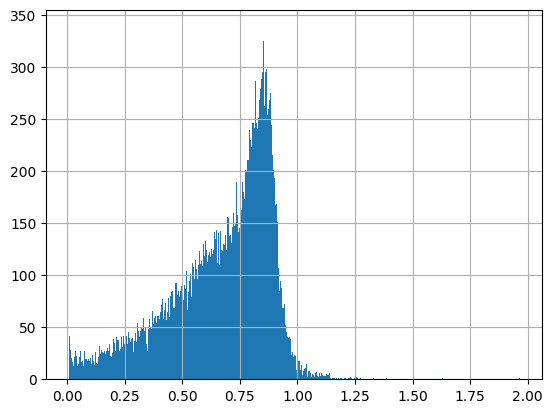

In [72]:
orig_measures_df["AUC"].hist(bins=1000)

In [78]:
# merge curvecurator and original fits
mapped_response_df = viability_df.merge(orig_measures_df, on=["cpd_name", "ccl_name"], how='left')
mapped_response_df

,Name,SignalQuality,pEC50_curvecurator,Slope,Front,Back,FoldChange,AUC_curvecurator,RMSE,R2,...,cell_line_id,drug_id,EC50_curvecurator,IC50_curvecurator,ccl_name,cpd_name,sample,drug,area_under_curve,AUC
0,CVCL_0006|387447,0.0,8.121074,10.000000,1.097185,0.031570,-4.985291,0.472640,0.039506,0.993924,...,CVCL_0006,387447,7.567035e-09,7.753043e-09,THP1,bortezomib,CVCL_0006,387447,3.31050,0.413813
1,CVCL_0007|387447,0.0,8.386980,10.000000,1.147691,0.010585,-6.561786,0.337758,0.085707,0.973699,...,CVCL_0007,387447,4.102228e-09,4.218800e-09,U937,bortezomib,CVCL_0007,387447,2.51780,0.314725
2,CVCL_0012|387447,0.0,8.577246,4.573292,1.030760,0.026085,-5.260615,0.225003,0.016225,0.998586,...,CVCL_0012,387447,2.647000e-09,2.713386e-09,LP1,bortezomib,CVCL_0012,387447,1.56290,0.195362
3,CVCL_0014|387447,0.0,8.526281,8.269879,1.043971,0.010244,-6.609083,0.239339,0.020866,0.998078,...,CVCL_0014,387447,2.976590e-09,3.014620e-09,RPMI8226,bortezomib,CVCL_0014,387447,1.62860,0.203575
4,CVCL_0024|387447,0.0,8.243077,3.748460,1.119518,0.016693,-5.903842,0.409407,0.170436,0.895521,...,CVCL_0024,387447,5.713767e-09,6.105049e-09,SCLC21H,bortezomib,CVCL_0024,387447,3.08140,0.385175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60752,CVCL_1662|100016,0.0,2.528659,0.560463,0.977548,0.000100,-0.524009,0.864628,0.056947,0.701450,...,CVCL_1662,100016,2.960337e-03,2.728323e-03,RMGI,zebularine,CVCL_1662,100016,6.03895,0.754869
60753,CVCL_1662|119607,0.0,3.613511,1.785789,0.894399,0.000100,-2.717681,0.711523,0.089469,0.905135,...,CVCL_1662,119607,2.434945e-04,2.132263e-04,RMGI,valdecoxib,CVCL_1662,119607,4.90615,0.613269
60754,CVCL_1662|216326,0.0,5.349522,10.000000,1.000023,0.931218,-0.102808,0.931982,0.047540,0.124025,...,CVCL_1662,216326,4.471758e-06,NaN,RMGI,lenalidomide,CVCL_1662,216326,6.53080,0.816350
60755,CVCL_1662|39562,0.0,3.375186,2.936334,0.933884,0.000100,-1.990078,0.847939,0.076599,0.893732,...,CVCL_1662,39562,4.215162e-04,4.016673e-04,RMGI,lonidamine,CVCL_1662,39562,5.91250,0.739062


<Axes: xlabel='AUC_curvecurator', ylabel='AUC'>

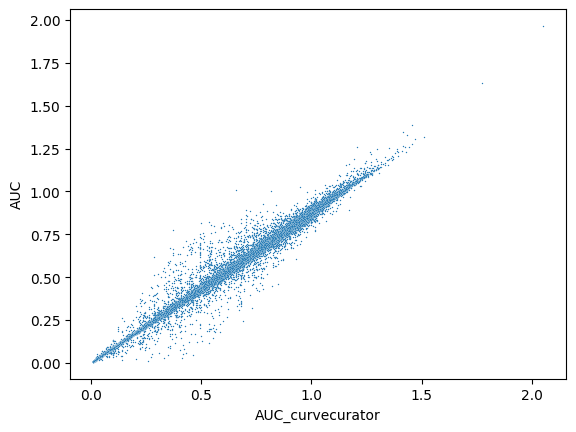

In [53]:
sns.scatterplot(mapped_response_df, x="AUC_curvecurator", y="AUC", s=1)

In [85]:
mapped_response_df.query("AUC<0.5")

,Name,SignalQuality,pEC50_curvecurator,Slope,Front,Back,FoldChange,AUC_curvecurator,RMSE,R2,...,cell_line_id,drug_id,EC50_curvecurator,IC50_curvecurator,ccl_name,cpd_name,sample,drug,area_under_curve,AUC
0,CVCL_0006|387447,0.0,8.121074,10.000000,1.097185,0.031570,-4.985291,0.472640,0.039506,0.993924,...,CVCL_0006,387447,7.567035e-09,7.753043e-09,THP1,bortezomib,CVCL_0006,387447,3.31050,0.413813
1,CVCL_0007|387447,0.0,8.386980,10.000000,1.147691,0.010585,-6.561786,0.337758,0.085707,0.973699,...,CVCL_0007,387447,4.102228e-09,4.218800e-09,U937,bortezomib,CVCL_0007,387447,2.51780,0.314725
2,CVCL_0012|387447,0.0,8.577246,4.573292,1.030760,0.026085,-5.260615,0.225003,0.016225,0.998586,...,CVCL_0012,387447,2.647000e-09,2.713386e-09,LP1,bortezomib,CVCL_0012,387447,1.56290,0.195362
3,CVCL_0014|387447,0.0,8.526281,8.269879,1.043971,0.010244,-6.609083,0.239339,0.020866,0.998078,...,CVCL_0014,387447,2.976590e-09,3.014620e-09,RPMI8226,bortezomib,CVCL_0014,387447,1.62860,0.203575
4,CVCL_0024|387447,0.0,8.243077,3.748460,1.119518,0.016693,-5.903842,0.409407,0.170436,0.895521,...,CVCL_0024,387447,5.713767e-09,6.105049e-09,SCLC21H,bortezomib,CVCL_0024,387447,3.08140,0.385175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60632,CVCL_2989|100016,0.0,5.252212,2.689566,0.999245,0.017548,-5.832297,0.091387,0.006592,0.999611,...,CVCL_2989,100016,5.594841e-06,5.666468e-06,KMS11,zebularine,CVCL_2989,100016,0.65383,0.081729
60687,CVCL_5031|100016,0.0,4.795174,4.849421,0.929449,0.237335,-2.075003,0.414675,0.069973,0.950933,...,CVCL_5031,100016,1.602603e-05,1.773593e-05,SNU175,zebularine,CVCL_5031,100016,2.91640,0.364550
60689,CVCL_5031|216326,0.0,5.458875,0.097911,0.999990,0.116189,-1.154465,0.500040,0.029864,0.966443,...,CVCL_5031,216326,3.476361e-06,5.176882e-05,SNU175,lenalidomide,CVCL_5031,216326,3.49890,0.437362
60697,CVCL_5098|100016,0.0,4.632868,2.280384,1.056376,0.071469,-3.794185,0.401740,0.069498,0.972341,...,CVCL_5098,100016,2.328799e-05,2.611284e-05,SNU81,zebularine,CVCL_5098,100016,2.87430,0.359287


(0.0, 1.5)

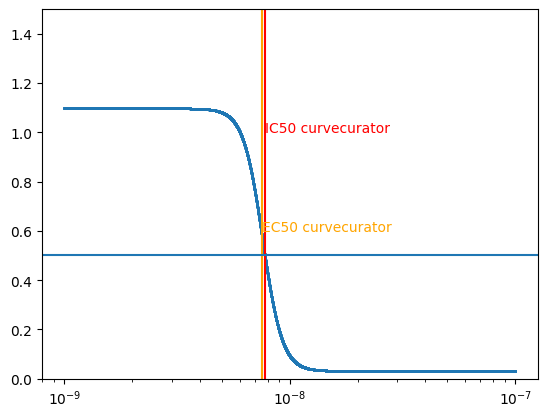

In [90]:
xvals = np.linspace(-9,-7, 10000)

index = 0
front = mapped_response_df.loc[index, "Front"]
back = mapped_response_df.loc[index, "Back"]
pec50 = mapped_response_df.loc[index, "pEC50_curvecurator"]
ec50 = mapped_response_df.loc[index, "EC50_curvecurator"]

slope = mapped_response_df.loc[index, "Slope"]
ic50 = mapped_response_df.loc[index, "IC50_curvecurator"]


y = (front - back) / (1 + 10 ** (slope * (xvals + pec50))) + back
plt.scatter(10**xvals, 	y, s=1)


plt.axvline(ic50, color="red")
plt.text(x=ic50, y=1.0, s='IC50 curvecurator', color='red')

plt.axvline(ec50, color="orange")
plt.text(x=ec50, y=0.6, s='EC50 curvecurator', color='orange')

plt.axhline(0.5)

plt.xscale('log')
plt.ylim(0,1.5)

In [91]:
mapped_response_df.to_csv("CTRPv1_for_drevalpy.csv")